# Principal Component Analisys (PCA)

## Data Import

### Import data from csv file

In [1]:
import pandas as pd
from io import StringIO

#import the data from the file
# The file "ModeChoiceOptima.txt" should be in the same directory as this script
with open("ModeChoiceOptima.txt", "r") as file:
    data = file.read()

# Assuming the data is in CSV format with ';' as the delimiter
df_input = pd.read_csv(StringIO(data), delimiter=';')
df = df_input.copy()

### Remove non-ordinary categories

In [2]:
#Drop Out non-ordinary Categories
columns_to_drop = ["DestAct", "HouseType", "OwnHouse", "Mothertongue", "OccupStat", "SocioProfCat", "Education", "TypeCommune", "ClassifCodeLine", "ResidChild", "Region", "Choice", "ModeToSchool", "CoderegionCAR", "Weight"]
df = df.drop(columns=columns_to_drop, errors='ignore')

### Remove Non Valid Aswers and scale data
On the dataset there is rows that have values -1 or -2 which represent that data is missing for that specific response. Those values are taken out and then data es standerdize.
The variation is also calculated to mantain the desired value of variance

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Drop the first column (ID) as it doesn't matter for PCA
filtered_df = df.drop(columns=['ID'])

# Filter out rows with -1 and -2 values
filtered_df = filtered_df[(filtered_df != -1).all(axis=1)]
filtered_df = filtered_df[(filtered_df != -2).all(axis=1)]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_df.select_dtypes(include=[float, int]))

# Calculate the covariance matrix
cov_matrix = np.cov(scaled_data.T)

# Calculate the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues in descending order
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

# Calculate the explained variance ratio
explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Select the number of principal components that explain at least 80% of the variance
n_components = np.argmax(cumulative_explained_variance_ratio >= 0.80) + 1

print("Number of principal components to explain at least 80% of the variance:", n_components)

Number of principal components to explain at least 80% of the variance: 48


## Perform PCA

In [4]:
from sklearn.decomposition import PCA

# Perform PCA with the specified number of components
pca = PCA(n_components=n_components)
principal_components = abs(pca.fit_transform(scaled_data.transpose()))

# normalize each row based as a percentage with the max value on it
principal_components = principal_components / np.max(principal_components, axis=1, keepdims=True)
principal_components = principal_components * 100

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(n_components)])

## Plot data as Heat Map

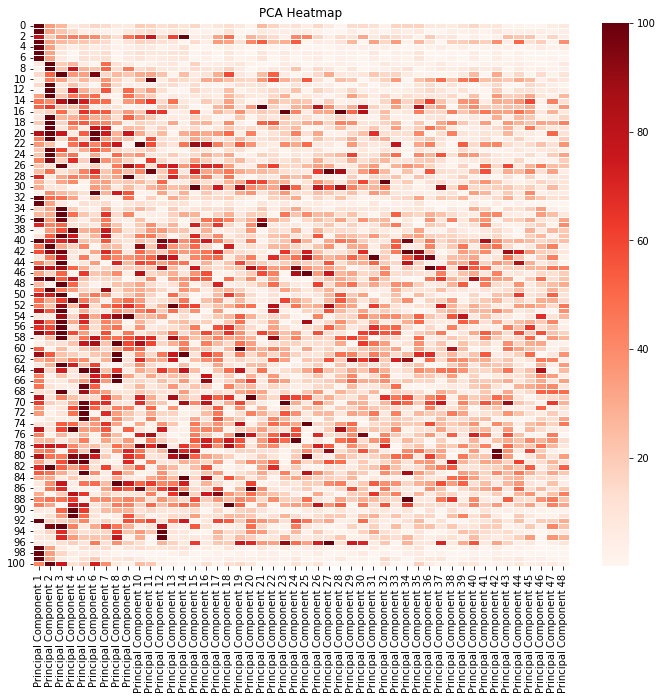

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the softmax principal components
softmax_pca_df = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(n_components)])

# Create a heat map
plt.figure(figsize=(12, 10))
sns.heatmap(softmax_pca_df, annot=False, cmap='Reds', linewidths=0.5)
plt.title('PCA Heatmap')
plt.show()

## Regularization using softmax

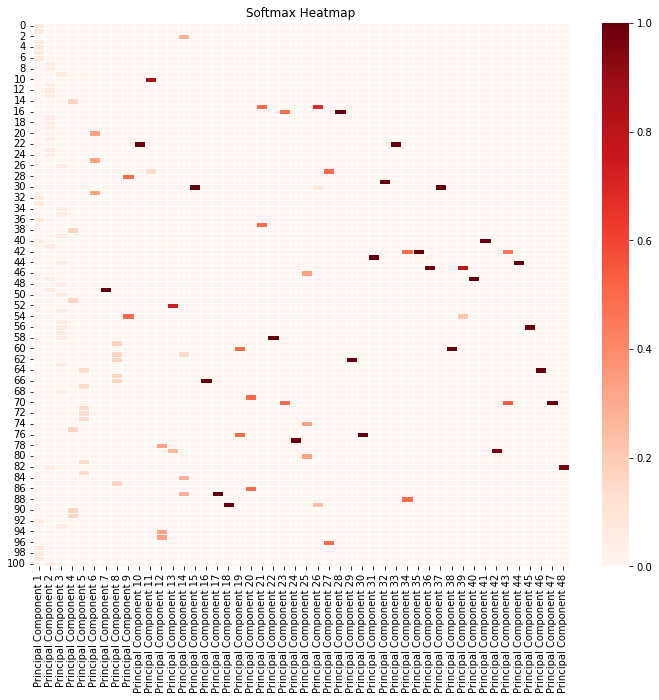

In [6]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Apply softmax to each of the principal components
softmax_principal_components = np.exp(principal_components) / np.sum(np.exp(principal_components), axis=0)

# Create a DataFrame with the softmax principal components
softmax_pca_df = pd.DataFrame(data=softmax_principal_components, columns=[f'Principal Component {i+1}' for i in range(n_components)])

# Create a heat map
plt.figure(figsize=(12, 10))
sns.heatmap(softmax_pca_df, annot=False, cmap='Reds', linewidths=0.5)
plt.title('Softmax Heatmap')
plt.show()

### Cut of variables based on thresshold
We define a thresshold that ensures that all questions fall in at least 1 class

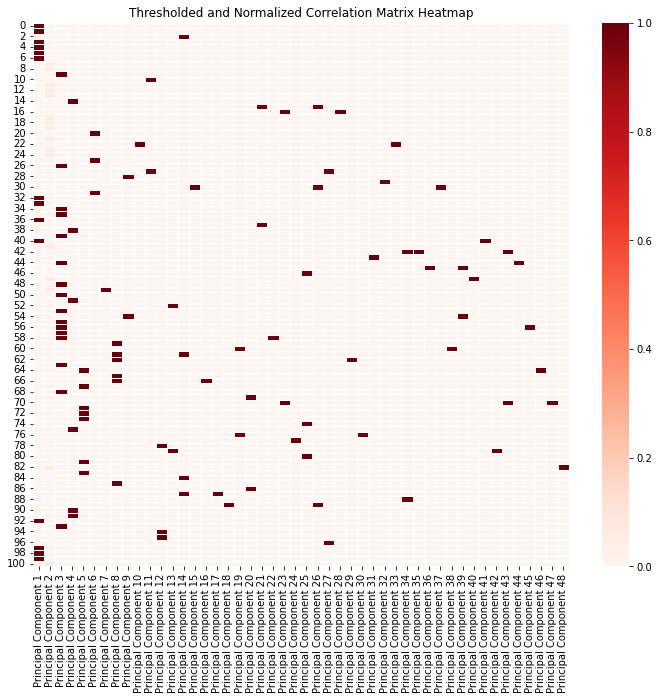

In [19]:
# Set values to the minimal value out of the classification
Thresshold = np.min(softmax_pca_df.max(axis=0))
thresholded_softmax_pca_df = softmax_pca_df.apply(lambda x: x.where(x >= Thresshold, 0))

filtered_pca_df = thresholded_softmax_pca_df

thresholded_softmax_pca_df = thresholded_softmax_pca_df.apply(lambda x: x.where(x <= Thresshold, 1))

# Plot the heatmap with the normalized values
plt.figure(figsize=(12, 10))
sns.heatmap(thresholded_softmax_pca_df, annot=False, cmap='Reds', linewidths=0.5)
plt.title('Thresholded and Normalized Correlation Matrix Heatmap')
plt.show()

## Data Result


In [20]:
# Read the file
with open("Questions.txt", "r") as file:
    questions_data = file.readlines()

# Split the data into short name and long name
questions = [line.strip().split(" - ") for line in questions_data]

# Create a dataframe
questions_df = pd.DataFrame(questions, columns=["Short name", "Long name"])

#calculate the indexes of the non-zero values in the thresholded softmax PCA DataFrame
non_zero_indexes = {col: thresholded_softmax_pca_df.index[thresholded_softmax_pca_df[col] != 0].tolist() for col in thresholded_softmax_pca_df.columns}

#for each non zero index, print the question
for col, indexes in non_zero_indexes.items():
    print(f"Principal Component {col.split()[-1]}:")
    for index in indexes:
        print(questions_df.iloc[index]['Long name'])
    print()

Principal Component 1:
Identifier of the respondent who described the trips in the loop.
Main activity at destination (1 to 11; -1 if missing).
The duration of the loop performed in public transport (in minutes).
The total walking time in a loop performed in public transports (in minutes).
The total waiting time in a loop performed in public transports (in minutes).
Cost for public transports (full cost to perform the loop).
I guess the income calculated
Highest education achieved (1 to 8).
GA (full Swiss season ticket) ownership (1 =yes; 2 =no).
The total cost of a loop performed in public transports, considering seasonal ticket ownership.
I always plan my activities well in advance.
The commune type (1 to 9) based on the Swiss Federal Statistical Office classification.
Binary variable: 1 =Rural; 2 =Urban.
Language of the commune (1 =French; 2 =German).

Principal Component 2:
The total gas cost of a loop performed with the car in euros.
The total duration of a loop made using the car

| Principal Component | Suggested Name                            | Reasoning                                                                 |
|---------------------|--------------------------------------------|---------------------------------------------------------------------------|
| PC1                 | Public Transport & Socioeconomic Profile   | Focus on PT usage, cost, time, income, education, urban/rural class.      |
| PC2                 | Car Ownership & Household Assets           | Car usage costs, vehicle counts, house type, internet, appliances.        |
| PC3                 | Mobility Behavior & Social Perception      | Travel habits, family reliance, social comfort during trips.              |
| PC4                 | Lifestyle Preferences                      | Preferences for dynamic life, work, ticket ownership.                     |
| PC5                 | Public Transport Familiarity               | Habits and life experience with public transport.                          |
| PC6                 | Household Income & Socio-Professional Status | Income, smartphones, social category.                                     |
| PC7                 | Activity Interference                      | Trip interfering with other desired activities.                            |
| PC8                 | Car Comfort & Time Reliability             | Convenience of car use, scheduling, parking.                              |
| PC9                 | Mobility Routine & Language                | Mothertongue and fixed transport habits.                                  |
| PC10                | Residence Ownership                        | Whether household owns the residence.                                     |
| PC11                | Demographics                               | Kids and age of respondent.                                               |
| PC12                | Social Openness & Routine                  | Comfort with strangers, routine lifestyle.                                |
| PC13                | Mode Choice Flexibility                    | Reconsideration of transport mode.                                        |
| PC14                | PT Transfers & Social Perception           | PT transfers and awareness of social cues.                                |
| PC15                | Occupational Status                        | Employment classification.                                                |
| PC16                | PT Navigation Knowledge                    | Knowledge of PT routes.                                                   |
| PC17                | Social Status Perception                   | Recognizing status by vehicles.                                           |
| PC18                | Car as Practical Tool                      | Viewing the car purely as utility.                                        |
| PC19                | Car Freedom & Housing Mobility             | Car liberty and housing accessibility.                                    |
| PC20                | Disorientation & Need for Breaks           | Feeling lost in new towns, need for rest.                                 |
| PC21                | Household Digitalization & PT Ownership    | Computers, PT area ticket ownership.                                      |
| PC22                | PT Difficulty with Luggage                 | Inconvenience of carrying luggage in PT.                                  |
| PC23                | Digital Tools for PT                       | Internet and tech use for planning trips.                                 |
| PC24                | Local Social Network                       | Friends living close.                                                     |
| PC25                | Environmental Concerns & PT Interaction    | Climate concern, PT driver interaction.                                   |
| PC26                | Material Assets & Practicality             | Computer ownership, job status, car practicality.                         |
| PC27                | Trip Purpose                               | Main goal of the trip loop.                                               |
| PC28                | Home Entertainment                         | Number of TVs.                                                            |
| PC29                | Parking Discomfort                         | Disliking the search for parking.                                         |
| PC30                | Housing & Mobility Conditions              | Housing choice influenced by mobility.                                    |
| PC31                | PT Investment Support                      | Willingness to pay taxes for PT.                                          |
| PC32                | Family Situation                           | Family structure.                                                         |
| PC33                | Home Ownership & Parking Issues            | Mix of housing and parking discomfort.                                    |
| PC34                | Materialistic Display                      | Showing off possessions.                                                  |
| PC35                | Environmental Taxes & PT Support           | Support for fuel taxes, more PT.                                          |
| PC36                | Employment Priority over Environment       | Favoring job creation over ecology.                                       |
| PC37                | Flexibility in Mode Choice                 | Open to changing travel modes.                                            |
| PC38                | Routine Travel Habits                      | Habitual transport behavior.                                              |
| PC39                | Social Trust & Environmental Trade-offs    | Community trust vs. environment vs. employment.                           |
| PC40                | Climate Action Support                     | Need for action on greenhouse gases.                                      |
| PC41                | PT Cost Consideration                      | Ticket ownership affecting PT cost.                                       |
| PC42                | Digital Tools for Mobility                 | Checking PT info online.                                                  |
| PC43                | Urban Living Preference                    | Wanting to live in city center.                                           |
| PC44                | Environmental Justice Concerns             | Ecology affecting minorities/businesses.                                  |
| PC45                | PT Perception                              | Public transport and city comfort.                                        |
| PC46                | PT Information & Interaction               | Schedule awareness, driver interaction.                                   |
| PC47                | PT Limitations on Activities               | Car enabling more activities than PT.                                     |
| PC48                | Outskirts Living Preference                | Desire to live in city outskirts.                                         |


In [21]:
pc_categories = {
    "Principal Component 1": ["Public Transport & Socioeconomic Profile"],
    "Principal Component 2": ["Car Ownership & Household Assets"],
    "Principal Component 3": ["Mobility Behavior & Social Perception"],
    "Principal Component 4": ["Lifestyle Preferences"],
    "Principal Component 5": ["Public Transport Familiarity"],
    "Principal Component 6": ["Household Income & Socio-Professional Status"],
    "Principal Component 7": ["Activity Interference"],
    "Principal Component 8": ["Car Comfort & Time Reliability"],
    "Principal Component 9": ["Mobility Routine & Language"],
    "Principal Component 10": ["Residence Ownership"],
    "Principal Component 11": ["Demographics"],
    "Principal Component 12": ["Social Openness & Routine"],
    "Principal Component 13": ["Mode Choice Flexibility"],
    "Principal Component 14": ["PT Transfers & Social Perception"],
    "Principal Component 15": ["Occupational Status"],
    "Principal Component 16": ["PT Navigation Knowledge"],
    "Principal Component 17": ["Social Status Perception"],
    "Principal Component 18": ["Car as Practical Tool"],
    "Principal Component 19": ["Car Freedom & Housing Mobility"],
    "Principal Component 20": ["Disorientation & Need for Breaks"],
    "Principal Component 21": ["Household Digitalization & PT Ownership"],
    "Principal Component 22": ["PT Difficulty with Luggage"],
    "Principal Component 23": ["Digital Tools for PT"],
    "Principal Component 24": ["Local Social Network"],
    "Principal Component 25": ["Environmental Concerns & PT Interaction"],
    "Principal Component 26": ["Material Assets & Practicality"],
    "Principal Component 27": ["Trip Purpose"],
    "Principal Component 28": ["Home Entertainment"],
    "Principal Component 29": ["Parking Discomfort"],
    "Principal Component 30": ["Housing & Mobility Conditions"],
    "Principal Component 31": ["PT Investment Support"],
    "Principal Component 32": ["Family Situation"],
    "Principal Component 33": ["Home Ownership & Parking Issues"],
    "Principal Component 34": ["Materialistic Display"],
    "Principal Component 35": ["Environmental Taxes & PT Support"],
    "Principal Component 36": ["Employment Priority over Environment"],
    "Principal Component 37": ["Flexibility in Mode Choice"],
    "Principal Component 38": ["Routine Travel Habits"],
    "Principal Component 39": ["Social Trust & Environmental Trade-offs"],
    "Principal Component 40": ["Climate Action Support"],
    "Principal Component 41": ["PT Cost Consideration"],
    "Principal Component 42": ["Digital Tools for Mobility"],
    "Principal Component 43": ["Urban Living Preference"],
    "Principal Component 44": ["Environmental Justice Concerns"],
    "Principal Component 45": ["PT Perception"],
    "Principal Component 46": ["PT Information & Interaction"],
    "Principal Component 47": ["PT Limitations on Activities"],
    "Principal Component 48": ["Outskirts Living Preference"],
}


# Create DataFrame with each principal component as a column
df_pc_categories = pd.DataFrame(pc_categories)


## Variables Coorrelation Test
We use the new transformation to check coorelation between diferent components

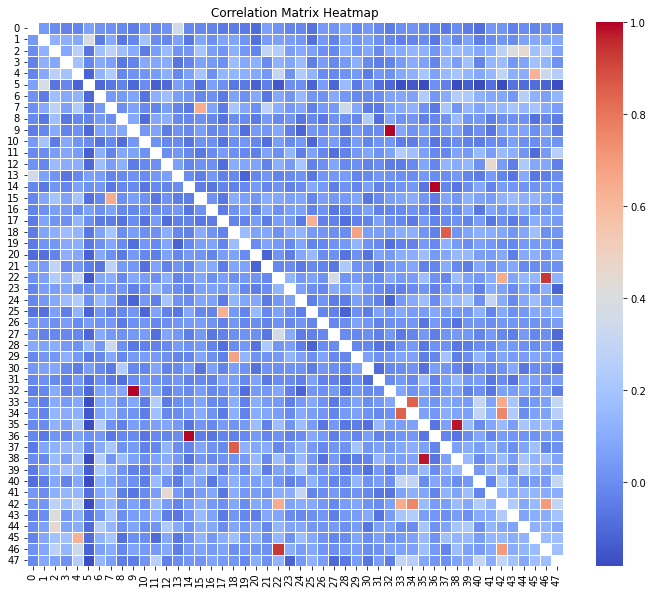

In [22]:
# Calculate the transformed data
transformed_data = np.dot(filtered_pca_df.values.T, filtered_df.T).T

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(transformed_data, rowvar=False)

# Discard the diagonal
np.fill_diagonal(correlation_matrix, np.nan)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, mask=np.isnan(correlation_matrix))
plt.title('Correlation Matrix Heatmap')
plt.show()

### Cut off with thresshold of 30%

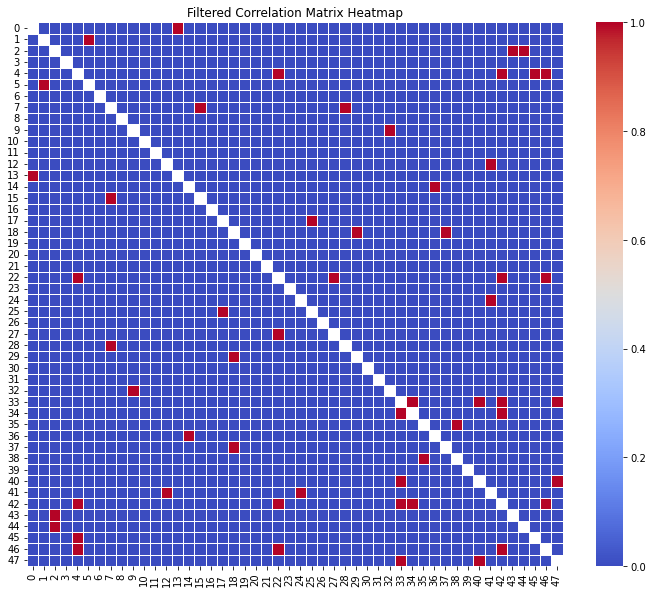

In [14]:
# Define the threshold
threshold = 0.3

# Apply the threshold to the correlation matrix
filtered_correlation_matrix = correlation_matrix.copy()
filtered_correlation_matrix[np.abs(filtered_correlation_matrix) >= threshold] = 1
filtered_correlation_matrix[np.abs(filtered_correlation_matrix) < threshold] = 0

# Plot the filtered heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, mask=np.isnan(filtered_correlation_matrix))
plt.title('Filtered Correlation Matrix Heatmap')
plt.show()